In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vtk_rw import read_vtk
import seaborn as sns

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### calculated from mesh

https://sites.google.com/site/dlampetest/python/calculating-normals-of-a-triangle-mesh-using-numpy

In [32]:
def calculate_normals(vertices, faces):
    
    triangles = vertices[faces]
    face_normals = np.cross( triangles[::,1 ] - triangles[::,0]  , triangles[::,2 ] - triangles[::,0] )
    face_normals /= 2 # weighting by surface area of the triangle, which is half the length of the normal
    
    vertex_normals = np.zeros(vertices.shape, dtype=vertices.dtype)
    vertex_count = np.zeros(vertices.shape[0])
    
    for face in range(faces.shape[0]):
        vertex_normals[faces[face]] += face_normals[face]
        vertex_count[faces[face]] += 1
   
    # here divide by actual number of faces, then normalize in the compare function
    vertex_normals /= vertex_count[:, np.newaxis]
    
    return vertex_normals

### from meshlab in object file

In [5]:
def read_obj(obj_file):
    obj_df=pd.read_csv(obj_file, header=None, engine='python', comment='#', sep=' ')
    obj_df=obj_df.dropna()

    vertex_df = obj_df.loc[np.where(obj_df[0] == 'v')[0]][[1,2,3]]
    vertex_array = np.asarray(vertex_df, dtype='float')

    if 'vn' in list(obj_df[0]):
        normals_df = obj_df.loc[np.where(obj_df[0] == 'vn')[0]][[1,2,3]]
        normals_array = np.asarray(normals_df, dtype='float')
    else:
        normals_array = np.empty(0)

    faces_df = obj_df.loc[np.where(obj_df[0] == 'f')[0]][[1,2,3]]
    faces_array = np.asarray(faces_df).copy()
    for i in range(faces_array.shape[0]):
        for j in range(faces_array.shape[1]):
            faces_array[i][j]=int(faces_array[i][j].split('//')[0])
    faces_array = np.asarray(faces_array, dtype='int64')-1
    
    return vertex_array, faces_array, normals_array

### comparing normals

In [83]:
def compare_normals(normals_a, normals_b):
    
    # normalize normals
    normals_a /= np.linalg.norm(normals_a, axis=1)[:,np.newaxis]
    normals_b /= np.linalg.norm(normals_b, axis=1)[:,np.newaxis]
    
    if np.any(np.isnan(normals_a)):
        raise ValueError('NaN in first set of normals')
    elif np.any(np.isnan(normals_b)):
        raise ValueError('NaN in second set of normals')
    else:
        pass
    
    # calculate angle between each pair of normals in radians
    diff_dot = np.zeros((normals_a.shape[0],))
    diff_rad = np.zeros((normals_a.shape[0],))
    for i in range(normals_a.shape[0]):
        diff_dot[i] = np.dot(normals_a[i], normals_b[i])
    # if the dot product ends up being a very small float point bigger than 1, np.arccos returns NaN
    # therefore set those cases to 1
    diff_dot[np.where(diff_dot>1)] = 1.
    diff_rad = np.arccos(diff_dot)
    
    # transform to degree angle
    diff_deg = diff_rad  * (180/np.pi)
    
    return diff_rad, diff_deg

In [84]:
simple_v, simple_f, obj_simple_normals = read_obj('/scr/ilz3/myelinconnect/groupavg/indv_space/BP4T/lowres_rh_d_def.obj')

In [85]:
calc_simple_normals = calculate_normals(simple_v, simple_f)

In [86]:
complex_v, complex_f, obj_complex_normals = read_obj('/scr/ilz3/myelinconnect/struct/surf_rh/orig/mid_surface/BP4T_rh_mid.obj')

In [87]:
calc_complex_normals = calculate_normals(complex_v, complex_f)

In [88]:
seed_mapping = np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/seeds/BP4T_rh_highres2lowres_seeds.npy')

In [89]:
obj_diff_rad, obj_diff_deg = compare_normals(obj_simple_normals, obj_complex_normals[seed_mapping])

In [90]:
calc_diff_rad, calc_diff_deg = compare_normals(calc_simple_normals, calc_complex_normals[seed_mapping])

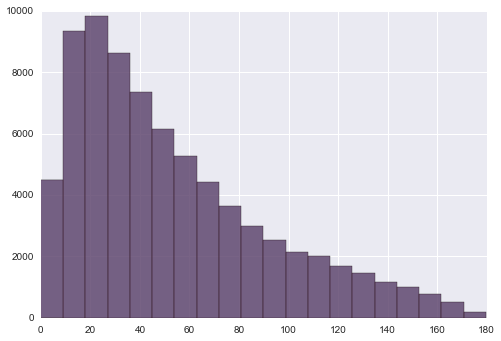

In [91]:
plt.hist(obj_diff_deg, bins=20, alpha=0.8);
plt.hist(calc_diff_deg, bins=20, alpha=0.3, color='darkred');

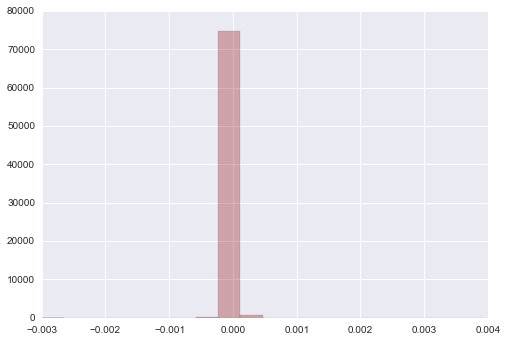

In [92]:
plt.hist(calc_diff_deg-obj_diff_deg, bins=20, alpha=0.3, color='darkred');

In [93]:
simple_calc_vs_obj_rad, simple_calc_vs_obj_deg = compare_normals(obj_simple_normals, calc_simple_normals)

In [94]:
complex_calc_vs_obj_rad, complex_calc_vs_obj_deg = compare_normals(obj_complex_normals, calc_complex_normals)

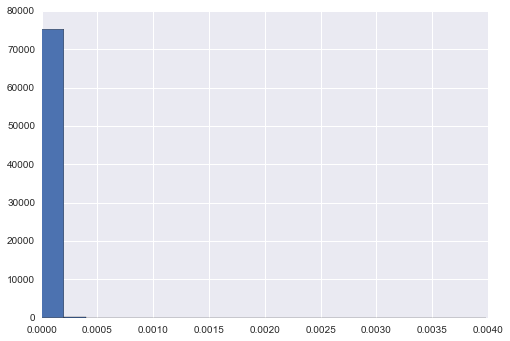

In [97]:
plt.hist(simple_calc_vs_obj_deg, bins=20);

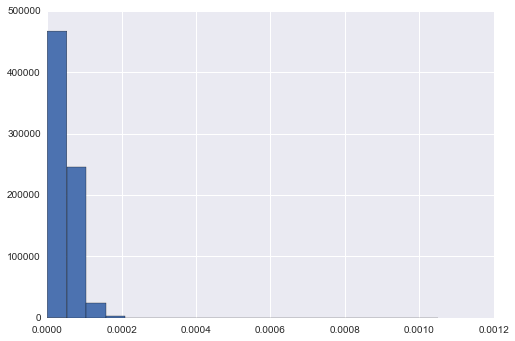

In [98]:
plt.hist(complex_calc_vs_obj_deg, bins=20);

### updating voronoi function to take into account normals

In [ ]:
simple_vertices=simple_v
simple_faces=simple_f
complex_vertices=complex_v
complex_faces=complex_f

In [ ]:
cutoff_angle = np.pi/2

In [ ]:
# find nearest neighbours of simple vertices on complex mesh using kdtree
inaccuracy, mapping  = spatial.KDTree(complex_vertices).query(simple_vertices[remaining_idxs], k=neighbours)

# create tidy long-format lists
simple_idxs = np.asarray([neighbours*[simple_idx] for simple_idx in remaining_idxs]).flatten()
candidate_idxs = mapping.flatten()
diff_euclid = inaccuracy.flatten()

# for each vertex pair calculate the angle between their normals
diff_normals, _ = compare_normals(simple_normals[simple_idxs], complex_normals[candidate_idxs])

# remove those pairs that have an angle > 90° and/or distance > 2 mm
mask = np.unique(np.concatenate((np.where(diff_euclid>cutoff_euclid)[0], np.where(diff_normals>cutoff_rad)[0])))
diff_normals = np.delete(diff_normals, mask)
diff_euclid = np.delete(diff_euclid, mask)
simple_idxs = np.delete(simple_idxs, mask)
candidate_idxs = np.delete(candidate_idxs, mask)

# calculate scores for each vertex pair
scores = (diff_normals-np.mean(diff_normals)) + (diff_euclid-np.mean(diff_euclid))

# make a binary search tree from the scores and vertex pairs, 
# organisation is key: score, values: tuple(simple_vertex, candiate_complex_vertex)
tree = FastAVLTree(zip(scores, zip(simple_idxs, candidate_idxs)))

while tree.count > 0:

    min_item =  tree.pop_min()
    simple_idx = min_item[1][0]
    candidate_idx = min_item[1][1]

    if (voronoi_seed_idx[simple_idx] == -1):
        if candidate_idx not in voronoi_seed_idx:
            voronoi_seed_idx[simple_idx] = candidate_idx
        else:
            pass
    else:
        pass

    missing = np.where(voronoi_seed_idx==-1)[0].shape[0]
    if missing == 0:
        break

In [ ]:
plt.hist(diff_normals-np.mean(diff_normals), alpha=0.5, bins=20)
plt.hist((diff_euclid-np.mean(diff_euclid)), alpha=0.5, bins=20, color='darkred')

In [ ]:
scores = (diff_normals-np.mean(diff_normals)) + (diff_euclid-np.mean(diff_euclid))

In [ ]:
plt.hist(scores);

In [ ]:
tree = FastAVLTree(zip(scores, zip(simple_idxs, candidate_idxs)))

In [ ]:
voronoi_seed_idx = np.zeros((simple_vertices.shape[0],), dtype='int64')-1
missing = np.where(voronoi_seed_idx==-1)[0].shape[0]

In [ ]:
min_item =  tree.pop_min()
simple_idx = min_item[1][0]
candidate_idx = min_item[1][1]

In [ ]:
simple_idx

In [ ]:
candidate_idx

In [ ]:
test_normals_simple =calculate_normals(simple_v, simple_f)
test_normals_complex =calculate_normals(complex_v, complex_f)

In [ ]:
test_normal, _ = compare_normals(test_normals_simple[simple_idx][np.newaxis, :], test_normals_complex[candidate_idx][np.newaxis, :])

In [ ]:
test_euclid = inaccuracy[simple_idx][np.where(mapping[simple_idx]==candidate_idx)]

In [ ]:
test_normal - np.mean(diff_normals) + test_euclid - np.mean(diff_euclid)

### check new mapping

In [ ]:
seed_mapping_fixed = np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/seeds_fixed/BP4T_rh_highres2lowres_seeds_test.npy')

In [ ]:
obj_diff_rad_fixed, obj_diff_deg_fixed = compare_normals(obj_simple_normals, obj_complex_normals[seed_mapping_fixed])

In [ ]:
calc_diff_rad_fixed, calc_diff_deg_fixed = compare_normals(calc_simple_normals, calc_complex_normals[seed_mapping_fixed])

In [ ]:
plt.hist(np.nan_to_num(obj_diff_deg_fixed), bins=20, alpha=0.8);
plt.hist(np.nan_to_num(calc_diff_deg_fixed), bins=10, alpha=0.3, color='darkred');